<a href="https://colab.research.google.com/github/Sushantstha2025/AI_worksheet/blob/main/2462001_Sushant_Shrestha_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# 1. Data Handling and Math
import pandas as pd
import numpy as np

# 2. Data Visualization (For your EDA - 20% marks)
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Preprocessing and Feature Selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer # Useful for filling missing values
from sklearn.feature_selection import SelectKBest, f_classif, f_regression

# 4. Classification Models (Adult Census Task)
from sklearn.neural_network import MLPClassifier  # Required Task 3.1
from sklearn.ensemble import RandomForestClassifier # Task 3.2
from sklearn.linear_model import LogisticRegression # Task 3.2
from sklearn.linear_model import Ridge # Task 3.2

# 5. Regression Models (Wanshouxigong Task)
from sklearn.neural_network import MLPRegressor    # Required Task 3.1
from sklearn.ensemble import RandomForestRegressor  # Task 3.2
from sklearn.linear_model import LinearRegression    # Task 3.2

# 6. Evaluation Metrics (Task 4)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 7. Hyperparameter Tuning (Task 4)
from sklearn.model_selection import GridSearchCV

# 8. Ignore warnings to keep the notebook clean
import warnings
warnings.filterwarnings('ignore')

In [21]:
# Load the data
df_diabetes = pd.read_csv('/content/drive/MyDrive/diabetic_data.csv')

df_diabetes.head()
df_diabetes.info()
df_diabetes.describe()

# 1. Replace '?' with NaN
df_diabetes.replace('?', np.nan, inplace=True)

# 2. Drop columns with too many missing values (Marks for 'Data Understanding')
# Weight is usually 97% missing in this dataset
df_diabetes.drop(['weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)

# 3. Handle 'age' (It is usually given as ranges like [40-50])
# We can convert it to the midpoint number to make it numerical
age_dict = {'[0-10)':5, '[10-20)':15, '[20-30)':25, '[30-40)':35, '[40-50)':45,
            '[50-60)':55, '[60-70)':65, '[70-80)':75, '[80-90)':85, '[90-100)':95}
df_diabetes['age'] = df_diabetes['age'].replace(age_dict).astype(int)

# 4. Drop IDs (They have no predictive power)
df_diabetes.drop(['encounter_id', 'patient_nbr'], axis=1, inplace=True)

# 5. Fill remaining missing values (race, diag_1, etc.) with Mode
for col in ['race', 'diag_1', 'diag_2', 'diag_3']:
    df_diabetes[col].fillna(df_diabetes[col].mode()[0], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

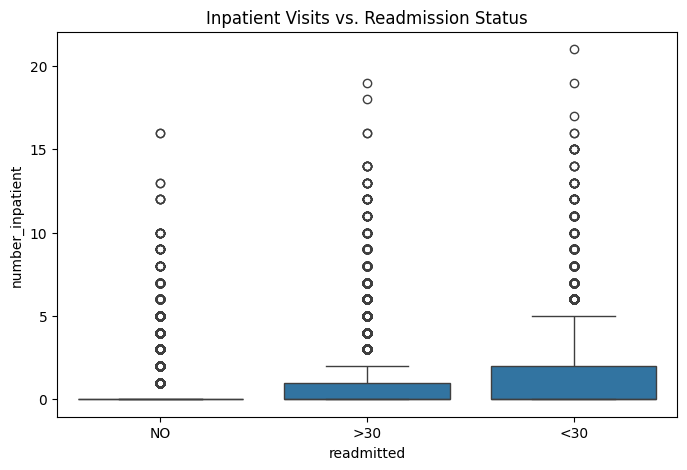

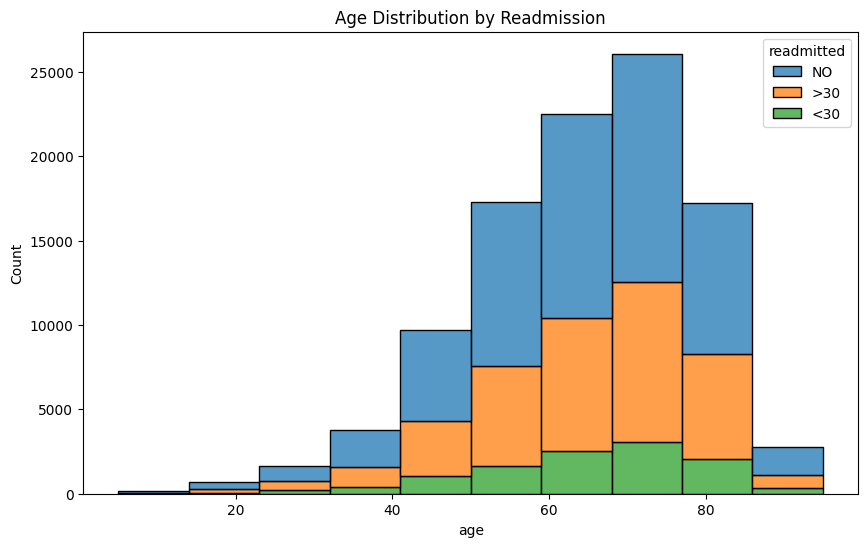

In [15]:
# Question 1: Does the number of inpatient visits influence readmission?
plt.figure(figsize=(8,5))
sns.boxplot(x='readmitted', y='number_inpatient', data=df_diabetes)
plt.title('Inpatient Visits vs. Readmission Status')
plt.show()
# Insight: Patients who were readmitted (1) tend to have a higher number of
# prior inpatient visits compared to those not readmitted (0).

# Question 2: Is there a relationship between age and readmission?
plt.figure(figsize=(10,6))
sns.histplot(data=df_diabetes, x='age', hue='readmitted', multiple='stack', bins=10)
plt.title('Age Distribution by Readmission')
plt.show()
# Insight: Readmissions are more frequent in the elderly age groups (70-90),
# suggesting that age is a significant risk factor.

In [16]:
# Create Binary Target: 1 if readmitted (any time), 0 if not
df_diabetes['readmitted'] = df_diabetes['readmitted'].replace({'<30': 1, '>30': 1, 'NO': 0})

# Label Encode the text columns (medications, gender, etc.)
categorical_cols = df_diabetes.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    df_diabetes[col] = le.fit_transform(df_diabetes[col].astype(str))

# Define X and y
X = df_diabetes.drop('readmitted', axis=1)
y = df_diabetes['readmitted']

# Split and Scale (CRITICAL for MLP)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Select the 10 most important features for hospital readmission
selector = SelectKBest(score_func=f_classif, k=10)
X_train_final = selector.fit_transform(X_train_scaled, y_train)
X_test_final = selector.transform(X_test_scaled)

# See what the computer picked (often 'number_inpatient' and 'number_diagnoses')
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: Index(['admission_source_id', 'time_in_hospital', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'change', 'diabetesMed'],
      dtype='object')


Best LR Params: {'C': 0.1, 'solver': 'liblinear'}, Score: 0.6168
Best RF Params: {'max_depth': 10, 'n_estimators': 100}, Score: 0.6252
MLP Accuracy: 0.6169303331040582

--- MLP Classification Report ---
              precision    recall  f1-score   support

           0       0.62      0.77      0.68     10952
           1       0.62      0.44      0.52      9402

    accuracy                           0.62     20354
   macro avg       0.62      0.60      0.60     20354
weighted avg       0.62      0.62      0.61     20354



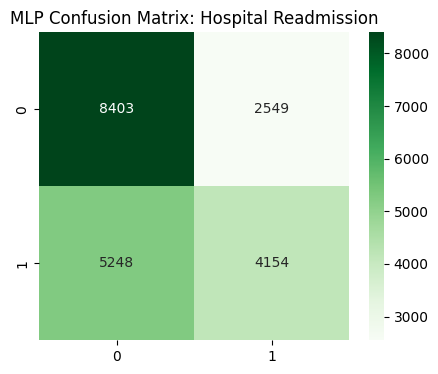

In [18]:
# --- Task 3.1: Neural Network (MLP) ---
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
mlp.fit(X_train_final, y_train)
y_pred_mlp = mlp.predict(X_test_final)

# --- Task 3.2: Comparison Model (Random Forest) ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_final, y_train)
y_pred_rf = rf.predict(X_test_final)

# --- Task 3 & 4: Classical Models & Tuning ---

# 1. Logistic Regression Tuning
param_grid_lr = {'C': [0.1, 1, 10], 'solver': ['liblinear']}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5)
grid_lr.fit(X_train_final, y_train)

# 2. Random Forest Tuning (Already have one, let's optimize it)
param_grid_rf = {'n_estimators': [50, 100], 'max_depth': [5, 10]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5)
grid_rf.fit(X_train_final, y_train)

print(f"Best LR Params: {grid_lr.best_params_}, Score: {grid_lr.best_score_:.4f}")
print(f"Best RF Params: {grid_rf.best_params_}, Score: {grid_rf.best_score_:.4f}")

# --- Task 4: Evaluation ---
print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("\n--- MLP Classification Report ---")
print(classification_report(y_test, y_pred_mlp))

# Confusion Matrix for MLP
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d', cmap='Greens')
plt.title('MLP Confusion Matrix: Hospital Readmission')
plt.show()

In [19]:
# Tuning the MLP
param_grid = {
    'hidden_layer_sizes': [(50,), (64, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam']
}

grid = GridSearchCV(MLPClassifier(max_iter=200, random_state=42), param_grid, cv=2, n_jobs=-1)
grid.fit(X_train_final, y_train)

print("Best Parameters Found:", grid.best_params_)

Best Parameters Found: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'solver': 'adam'}


In [20]:
# Rebuild with optimal settings
final_lr = grid_lr.best_estimator_
final_rf = grid_rf.best_estimator_

# Get Final Metrics for the table
def get_final_stats(model, name):
    preds = model.predict(X_test_final)
    acc = accuracy_score(y_test, preds)
    # We use 'macro' or 'weighted' for precision/recall/f1
    from sklearn.metrics import precision_score, recall_score, f1_score
    p = precision_score(y_test, preds)
    r = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    return [name, acc, p, r, f1]

# Create the Table data
results = [
    get_final_stats(mlp, "MLP (Neural Network)"),
    get_final_stats(final_rf, "Random Forest"),
    get_final_stats(final_lr, "Logistic Regression")
]

# Display as DataFrame
comparison_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
print(comparison_df)

                  Model  Accuracy  Precision    Recall  F1-Score
0  MLP (Neural Network)  0.616930   0.619723  0.441821  0.515865
1         Random Forest  0.622384   0.618214  0.477239  0.538655
2   Logistic Regression  0.617520   0.640389  0.392257  0.486511


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# 1. Load the dataset
df_reg = pd.read_csv('/content/drive/MyDrive/PRSA_Data_Wanshouxigong_20130301-20170228.csv')

# 2. Cleaning: Handle missing values with median for robustness
df_reg = df_reg.fillna(df_reg.median(numeric_only=True))

# 3. Create 'date' for EDA before dropping time columns
df_reg['date'] = pd.to_datetime(df_reg[['year', 'month', 'day', 'hour']])

# 4. Drop columns that won't be used as features (Task 5 requirement)
# We drop 'No' (index), 'station' (constant), 'wd' (string), and date columns
df_reg_clean = df_reg.drop(['No', 'station', 'wd', 'year', 'month', 'day', 'hour', 'date'], axis=1)

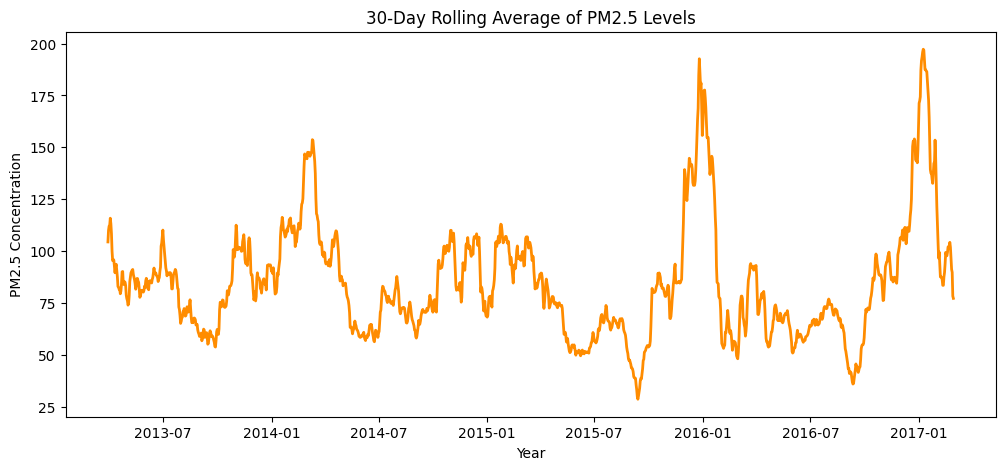

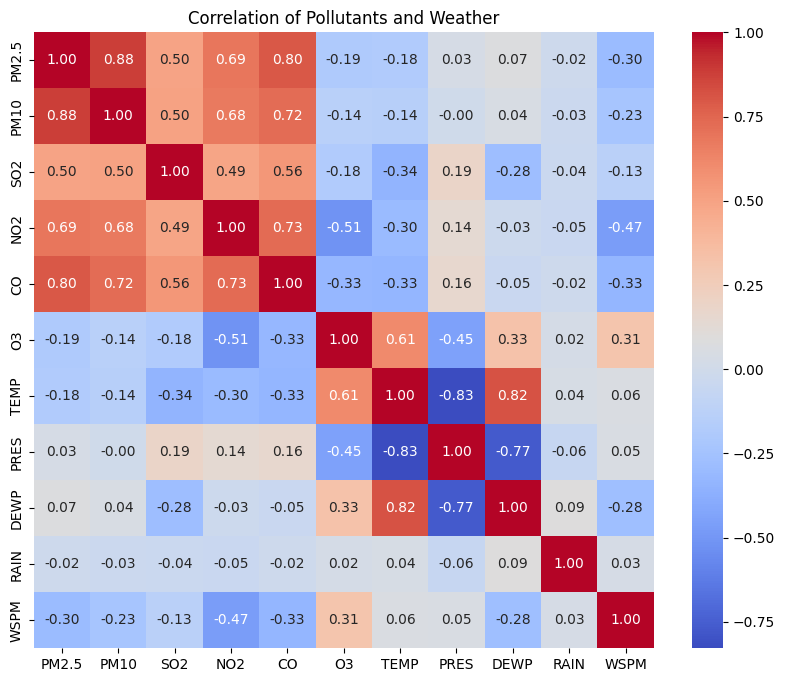

In [32]:
# Visualization A: Time-Series Trend
# Convert date column properly
rolling_pm25 = daily_pm25.rolling(window=30).mean()

plt.figure(figsize=(12,5))
plt.plot(rolling_pm25, color='darkorange', linewidth=2)
plt.title('30-Day Rolling Average of PM2.5 Levels')
plt.ylabel('PM2.5 Concentration')
plt.xlabel('Year')
plt.show()

print('\n')

# Visualization B: Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_reg_clean.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation of Pollutants and Weather')
plt.show()

In [27]:
# 1. Split Features and Target
X_r = df_reg_clean.drop('PM2.5', axis=1)
y_r = df_reg_clean['PM2.5']

# 2. Split into Training and Testing (Task 3.1)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.2, random_state=42)

# 3. Scaling (Mandatory for MLP)
scaler_r = StandardScaler()
X_train_scaled_r = scaler_r.fit_transform(X_train_r)
X_test_scaled_r = scaler_r.transform(X_test_r)

# 4. Feature Selection: Select Top 10 Features
selector_r = SelectKBest(score_func=f_regression, k=10)
X_train_final_r = selector_r.fit_transform(X_train_scaled_r, y_train_r)
X_test_final_r = selector_r.transform(X_test_scaled_r)

selected_names = X_r.columns[selector_r.get_support()]
print("Features Selected:", selected_names.tolist())

Features Selected: ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']


In [28]:
# --- Model 1: Ridge Regression Tuning ---
param_grid_ridge = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5)
grid_ridge.fit(X_train_final_r, y_train_r)

# --- Model 2: Random Forest Tuning ---
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20]
}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3)
grid_rf.fit(X_train_final_r, y_train_r)

print(f"Best Ridge Alpha: {grid_ridge.best_params_}")
print(f"Best RF Params: {grid_rf.best_params_}")

Best Ridge Alpha: {'alpha': 10.0}
Best RF Params: {'max_depth': 20, 'n_estimators': 100}


In [29]:
# 1. Rebuild MLP (Task 3.1)
mlp_reg = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp_reg.fit(X_train_final_r, y_train_r)

# 2. Rebuild Optimal Classical Models (Task 6)
final_ridge = grid_ridge.best_estimator_
final_rf = grid_rf.best_estimator_

# 3. Final Evaluation
def evaluate(model, name):
    preds = model.predict(X_test_final_r)
    rmse = np.sqrt(mean_squared_error(y_test_r, preds))
    r2 = r2_score(y_test_r, preds)
    return [name, r2, rmse]

results = [
    evaluate(mlp_reg, "MLP (Neural Network)"),
    evaluate(final_rf, "Random Forest (Tuned)"),
    evaluate(final_ridge, "Ridge Regression (Tuned)")
]

# 4. Table 1 (Sample Format)
table_final = pd.DataFrame(results, columns=['Model', 'R2 Score', 'RMSE'])
print(table_final)

                      Model  R2 Score       RMSE
0      MLP (Neural Network)  0.910739  25.099143
1     Random Forest (Tuned)  0.914096  24.622672
2  Ridge Regression (Tuned)  0.827312  34.910740
